# Code 4: Adversarial Attacks on Robust Facial Recognition Model

> Dissertation Task-1 (6812009)

### White Box Attacks

In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GaussianNoise, Conv2D, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tensorflow.keras.optimizers import Nadam

# Loading Olivetti Faces dataset again for testing
data = fetch_olivetti_faces()
X = data.images
y = data.target
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the WatermarkLayer
class WatermarkLayer(tf.keras.layers.Layer):
    def __init__(self, intensity=0.001, **kwargs):
        super(WatermarkLayer, self).__init__(**kwargs)
        self.intensity = intensity

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=input_shape[1:],
                                      initializer='uniform',
                                      trainable=True)
        super(WatermarkLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs + self.kernel * self.intensity

    def compute_output_shape(self, input_shape):
        return input_shape

# Loading the model with custom WatermarkLayer
with tf.keras.utils.custom_object_scope({'WatermarkLayer': WatermarkLayer}):
    model = load_model('FR_Olivetti_Robust_CNN_Model.h5')

# Evaluate the loaded model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy of the watermarked model: {test_acc}")

# Identifying the Watermarked Layers
print("\nIdentifying Watermarked Layers:")
for layer in model.layers:
    if isinstance(layer, WatermarkLayer):
        print(f"Watermarked Layer: {layer.name} with intensity: {layer.intensity}")

C:\Users\user\AppData\Local\Temp\ipykernel_24044\3790287385.py:24: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(WatermarkLayer, self).__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy of the watermarked model: 1.0

Identifying Watermarked Layers:
Watermarked Layer: watermark_layer with intensity: 0.001
Watermarked Layer: watermark_layer_1 with intensity: 0.001
Watermarked Layer: watermark_layer_2 with intensity: 0.001


In [2]:
# Function to add Gaussian noise to input data
def add_gaussian_noise(X, mean=0.0, stddev=0.1):
    noise = np.random.normal(mean, stddev, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0., 1.)

# Function to add salt-and-pepper noise to input data
def add_salt_and_pepper_noise(X, amount=0.1, salt_vs_pepper=0.5):
    X_noisy = X.copy()
    num_salt = np.ceil(amount * X.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X.size * (1.0 - salt_vs_pepper))

    coords_salt = [np.random.randint(0, i, int(num_salt)) for i in X.shape]
    coords_pepper = [np.random.randint(0, i, int(num_pepper)) for i in X.shape]
    
    X_noisy[tuple(coords_salt)] = 1
    X_noisy[tuple(coords_pepper)] = 0
    return X_noisy

# Function to add speckle noise to input data
def add_speckle_noise(X):
    noise = np.random.randn(*X.shape)
    X_noisy = X + X * noise
    return np.clip(X_noisy, 0., 1.)

# Function to add Poisson noise to input data
def add_poisson_noise(X):
    vals = len(np.unique(X))
    vals = 2 ** np.ceil(np.log2(vals))
    X_noisy = np.random.poisson(X * vals) / float(vals)
    return np.clip(X_noisy, 0., 1.)

# Function to add uniform noise to input data
def add_uniform_noise(X, low=0.0, high=0.1):
    noise = np.random.uniform(low, high, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, 0., 1.)

# List of noise functions for input data
noise_functions = [
    ('Gaussian Noise', add_gaussian_noise),
    ('Salt-and-Pepper Noise', add_salt_and_pepper_noise),
    ('Speckle Noise', add_speckle_noise),
    ('Poisson Noise', add_poisson_noise),
    ('Uniform Noise', add_uniform_noise)
]

# Applying noise to input data and evaluating the model
for name, noise_func in noise_functions:
    X_test_noisy = noise_func(X_test)
    test_loss, test_acc = model.evaluate(X_test_noisy, y_test)
    print(f"Test accuracy with {name} on input: {test_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 2.9375e-06
Test accuracy with Gaussian Noise on input: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.3683e-05
Test accuracy with Salt-and-Pepper Noise on input: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9681 - loss: 0.0720
Test accuracy with Speckle Noise on input: 0.9750000238418579
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 2.6631e-06
Test accuracy with Poisson Noise on input: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 3.8234e-05
Test accuracy with Uniform Noise on input: 1.0


In [3]:
# Function to perturb weights of a single layer
def perturb_weights_single_layer(model, layer_index, stddev=0.1):
    perturbed_model = tf.keras.models.clone_model(model)
    perturbed_model.set_weights(model.get_weights())
    layer = perturbed_model.layers[layer_index]
    if hasattr(layer, 'kernel'):
        original_weights = layer.get_weights()
        new_weights = [w + np.random.normal(0, stddev, w.shape) for w in original_weights]
        layer.set_weights(new_weights)
    return perturbed_model

# Function to perturb weights of multiple layers
def perturb_weights_multiple_layers(model, layer_indices, stddev=0.1):
    perturbed_model = tf.keras.models.clone_model(model)
    perturbed_model.set_weights(model.get_weights())
    for layer_index in layer_indices:
        layer = perturbed_model.layers[layer_index]
        if hasattr(layer, 'kernel'):
            original_weights = layer.get_weights()
            new_weights = [w + np.random.normal(0, stddev, w.shape) for w in original_weights]
            layer.set_weights(new_weights)
    return perturbed_model

# Function to add Gaussian noise to intermediate layers
def add_gaussian_noise_to_layer(model, layer_index, stddev=0.1):
    new_model = Sequential()
    for i, layer in enumerate(model.layers):
        new_model.add(layer)
        if i == layer_index:
            new_model.add(GaussianNoise(stddev))
    return new_model

In [4]:
# Evaluating model with perturbed weights (single layer)
for i, layer in enumerate(model.layers):
    perturbed_model = perturb_weights_single_layer(model, i)
    perturbed_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_acc = perturbed_model.evaluate(X_test, y_test)
    print(f"Test accuracy with perturbed weights in layer {i}: {test_acc}")

C:\Users\user\AppData\Local\Temp\ipykernel_24044\3790287385.py:24: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(WatermarkLayer, self).__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with perturbed weights in layer 0: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0013   
Test accuracy with perturbed weights in layer 1: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with perturbed weights in layer 2: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with perturbed weights in layer 3: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9650 - loss: 0.0885
Test accuracy with perturbed weights in layer 4: 0.9750000238418579
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with perturbed weights in layer 5: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with perturbed weights in layer 6: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accura

In [5]:
# 1. Evaluating model with perturbed weights (3 layers)
layer_indices = random.sample(range(len(model.layers)), 3)
perturbed_model = perturb_weights_multiple_layers(model, layer_indices)
perturbed_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = perturbed_model.evaluate(X_test, y_test)
print(f"Test accuracy with perturbed weights in layers {layer_indices}: {test_acc}")

# 2. Evaluating model with perturbed weights (3 layers)
layer_indices = random.sample(range(len(model.layers)), 3)
perturbed_model = perturb_weights_multiple_layers(model, layer_indices)
perturbed_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = perturbed_model.evaluate(X_test, y_test)
print(f"Test accuracy with perturbed weights in layers {layer_indices}: {test_acc}")

# 3. Evaluating model with perturbed weights (2 layers)
layer_indices = random.sample(range(len(model.layers)), 2)
perturbed_model = perturb_weights_multiple_layers(model, layer_indices)
perturbed_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = perturbed_model.evaluate(X_test, y_test)
print(f"Test accuracy with perturbed weights in layers {layer_indices}: {test_acc}")

# 4. Evaluating model with perturbed weights (2 layers)
layer_indices = random.sample(range(len(model.layers)), 2)
perturbed_model = perturb_weights_multiple_layers(model, layer_indices)
perturbed_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = perturbed_model.evaluate(X_test, y_test)
print(f"Test accuracy with perturbed weights in layers {layer_indices}: {test_acc}")

C:\Users\user\AppData\Local\Temp\ipykernel_24044\3790287385.py:24: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(WatermarkLayer, self).__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9852 - loss: 0.0193
Test accuracy with perturbed weights in layers [10, 4, 0]: 0.9916666746139526
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 9.0273e-06
Test accuracy with perturbed weights in layers [9, 8, 7]: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8462 - loss: 0.7083
Test accuracy with perturbed weights in layers [2, 1]: 0.8500000238418579
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5208e-05
Test accuracy with perturbed weights in layers [0, 4]: 1.0


In [6]:
# Evaluating model with Gaussian noise in single layers
for i, layer in enumerate(model.layers):
    noisy_layer_model = add_gaussian_noise_to_layer(model, i)
    noisy_layer_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    test_loss, test_acc = noisy_layer_model.evaluate(X_test, y_test)
    print(f"Test accuracy with Gaussian noise in layer {i}: {test_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 0: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 2.5562e-06 
Test accuracy with Gaussian noise in layer 1: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 2: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 3: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 4: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 5: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layer 6: 1.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in laye

In [7]:
# Evaluating model with Gaussian noise in intermediate layers (multiple layers)
layer_indices = random.sample([i for i, layer in enumerate(model.layers) if isinstance(layer, (Conv2D, Dense))], 3)
new_model = Sequential()
for i, layer in enumerate(model.layers):
    new_model.add(layer)
    if i in layer_indices:
        new_model.add(GaussianNoise(0.1))
new_model.compile(optimizer=Nadam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = new_model.evaluate(X_test, y_test)
print(f"Test accuracy with Gaussian noise in layers {layer_indices}: {test_acc}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with Gaussian noise in layers [4, 10, 1]: 1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


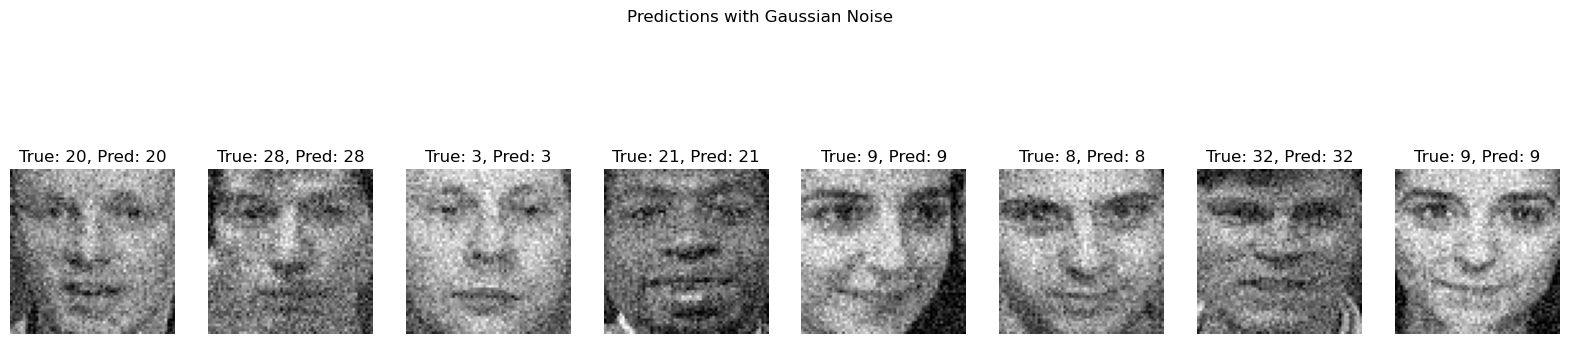

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


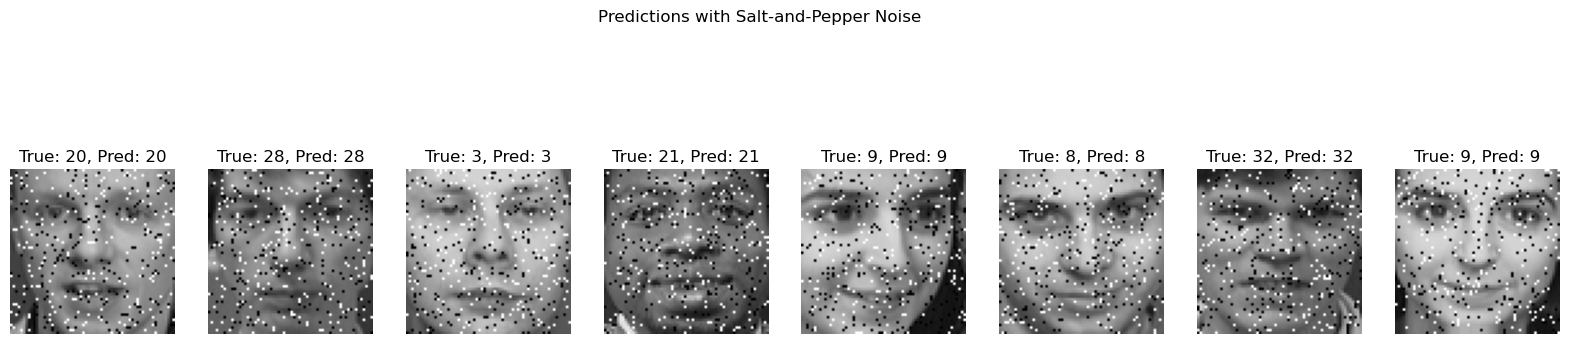

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


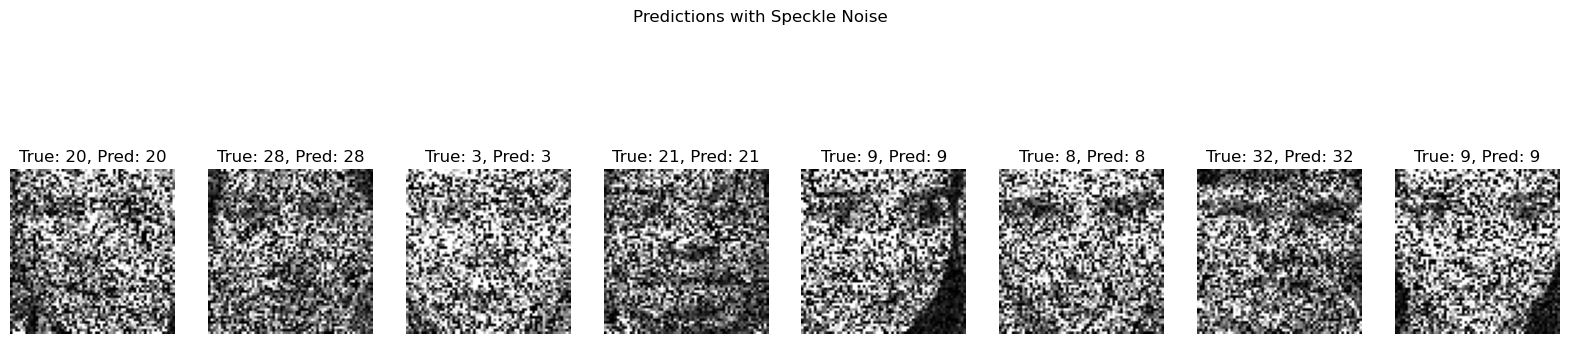

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


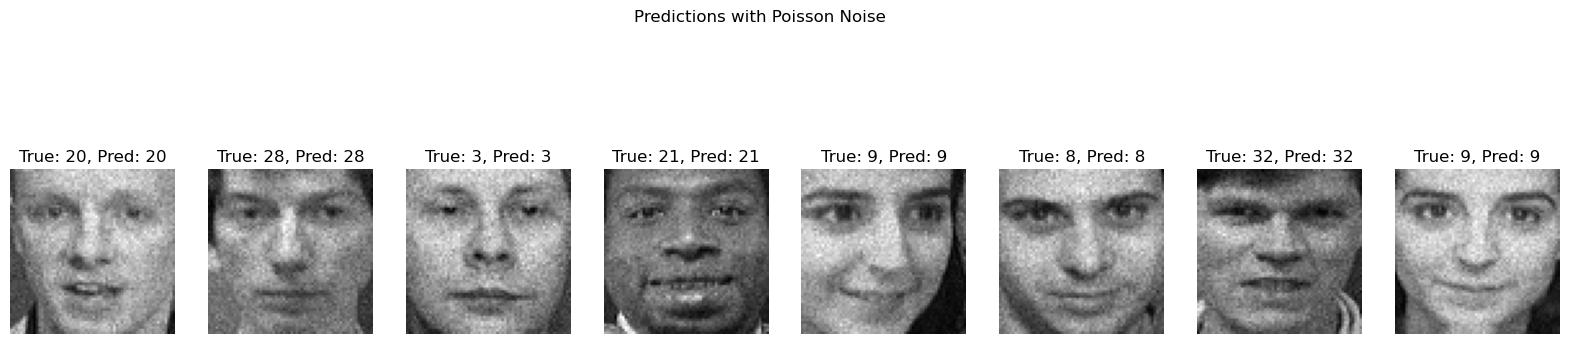

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


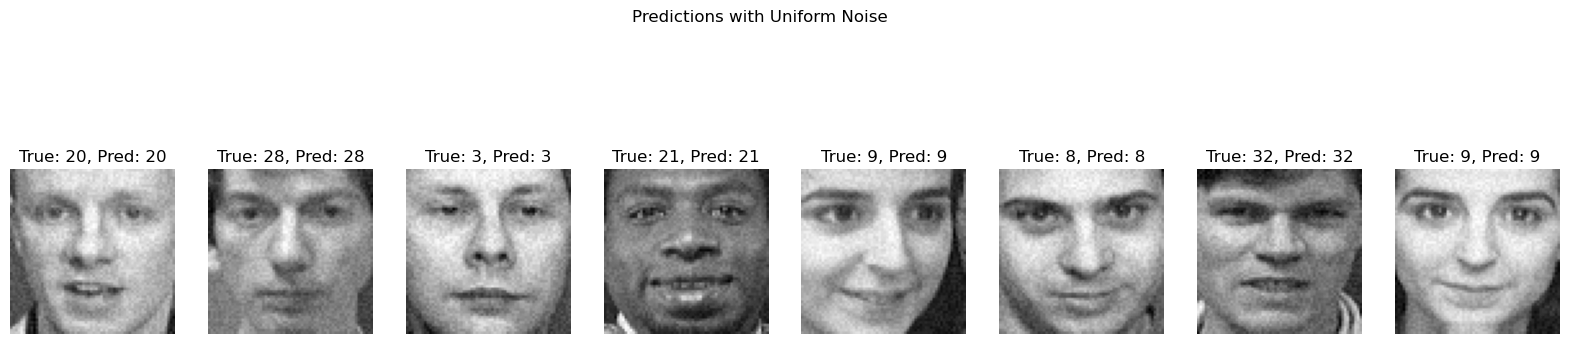

In [8]:
# Visualizing some of the predictions with different noises
num_images = 8
for name, noise_func in noise_functions:
    X_test_noisy = noise_func(X_test)
    predictions = model.predict(X_test_noisy)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(X_test_noisy[i].reshape(64, 64), cmap='gray')
        true_label = np.argmax(y_test[i])
        predicted_label = np.argmax(predictions[i])
        ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
        ax.axis('off')
    plt.suptitle(f'Predictions with {name}')
    plt.show()

### Black Box Attacks

In [5]:
pip install adversarial-robustness-toolbox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from art.attacks.evasion import (
    FastGradientMethod,
    ProjectedGradientDescent,
    CarliniL2Method,
    NewtonFool,
    DeepFool,
    BasicIterativeMethod,
)
from art.estimators.classification import TensorFlowV2Classifier

# Defining the WatermarkLayer
class WatermarkLayer(tf.keras.layers.Layer):
    def __init__(self, intensity=0.001, **kwargs):
        super(WatermarkLayer, self).__init__(**kwargs)
        self.intensity = intensity

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=input_shape[1:],
                                      initializer='uniform',
                                      trainable=True)
        super(WatermarkLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs + self.kernel * self.intensity

    def compute_output_shape(self, input_shape):
        return input_shape

# Loading the model with custom WatermarkLayer
with tf.keras.utils.custom_object_scope({'WatermarkLayer': WatermarkLayer}):
    model = load_model('FR_Olivetti_Robust_CNN_Model.h5')

# Loading Olivetti Faces dataset
data = fetch_olivetti_faces()
X = data.images
y = data.target

# Preprocessing data
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1).astype(np.float32)
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining the loss function used in the original model
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Creating ART classifier with the specified loss function
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(64, 64, 1),
    loss_object=loss_object,
)

# Listing the attacks to evaluate
attacks = [
    ("FGSM", FastGradientMethod(estimator=classifier, eps=0.03)),
    ("PGD", ProjectedGradientDescent(estimator=classifier, eps=0.03, eps_step=0.01, max_iter=20)),
    ("DeepFool", DeepFool(classifier=classifier)),
    ("CarliniL2", CarliniL2Method(classifier=classifier, confidence=0.0, max_iter=20)),
    ("NewtonFool", NewtonFool(classifier=classifier)),
    ("BasicIterative", BasicIterativeMethod(estimator=classifier, eps=0.03, eps_step=0.01, max_iter=20)),
]

# Evaluating each attack
for attack_name, attack in attacks:
    print(f"Running {attack_name} attack...")
    # Generating adversarial examples
    adv_x = attack.generate(x=X_test)
    # Evaluating the adversarial examples
    test_loss, test_acc = model.evaluate(adv_x, y_test)
    print(f"Test accuracy with {attack_name} attack: {test_acc}")

C:\Users\user\AppData\Local\Temp\ipykernel_8392\4235886315.py:20: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(WatermarkLayer, self).__init__(**kwargs)


Running FGSM attack...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0033
Test accuracy with FGSM attack: 1.0
Running PGD attack...


PGD - Batches: 0it [00:00, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9710 - loss: 0.1118
Test accuracy with PGD attack: 0.9666666388511658
Running DeepFool attack...


DeepFool:   0%|          | 0/120 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1275 - loss: 1137.2544
Test accuracy with DeepFool attack: 0.10000000149011612
Running CarliniL2 attack...


C&W L_2:   0%|          | 0/120 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 2.5562e-06
Test accuracy with CarliniL2 attack: 1.0
Running NewtonFool attack...


NewtonFool:   0%|          | 0/120 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8231 - loss: 0.6456
Test accuracy with NewtonFool attack: 0.8416666388511658
Running BasicIterative attack...


PGD - Batches: 0it [00:00, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9710 - loss: 0.1118
Test accuracy with BasicIterative attack: 0.9666666388511658
